# Grafice Ilustrative pentru ecuatiile luminii

## Importare biblioteci necesare

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch, torch.nn as nn
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [5]:
Path("plots").mkdir(exist_ok=True)
Path("data").mkdir(exist_ok=True)
plt.style.use('seaborn-v0_8-whitegrid')

## Reflexie

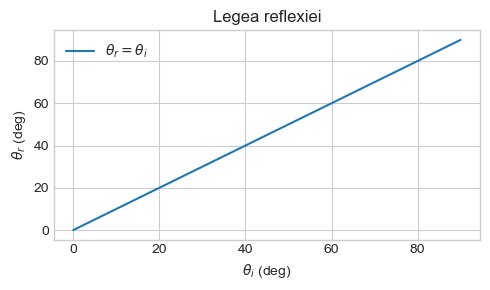

In [6]:
theta_i = np.linspace(0, 90, 500)
theta_r = theta_i
plt.figure(figsize=(5, 3))
plt.plot(theta_i, theta_r, label=r"$\theta_r = \theta_i$", color="C0")
plt.xlabel(r"$\theta_i$ (deg)")
plt.ylabel(r"$\theta_r$ (deg)")
plt.title("Legea reflexiei")
plt.legend()
plt.tight_layout()
plt.savefig("plots/reflection.png", dpi=300)

## Refractie

In [7]:
def build_snell_dataset(n=1000):
    rng = np.random.default_rng(42)
    n1 = rng.uniform(1.0, 1.5, n)
    n2 = rng.uniform(1.3, 2.0, n)
    theta1_deg = rng.uniform(0, 80, n)
    theta1_rad = np.radians(theta1_deg)

    # evităm total-reflexia: sinθ₁ ≤ n₂/n₁
    sin_max = n2 / n1
    mask = np.sin(theta1_rad) <= sin_max
    n1, n2, theta1_deg, theta1_rad = n1[mask], n2[mask], theta1_deg[mask], theta1_rad[mask]

    theta2_rad = np.arcsin((n1 / n2) * np.sin(theta1_rad))
    theta2_deg = np.degrees(theta2_rad)

    return pd.DataFrame({"n1": n1, "n2": n2, "theta1": theta1_deg, "theta2": theta2_deg})

/var/folders/v9/l8dwmpq12gz43xchbrk2wxh80000gn/T/ipykernel_14580/1244931108.py:14: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/v9/l8dwmpq12gz43xchbrk2wxh80000gn/T/ipykernel_14580/1244931108.py:15: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig("plots/snell_ml.png", dpi=300)
/usr/local/Caskroom/miniforge/base/envs/manim-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


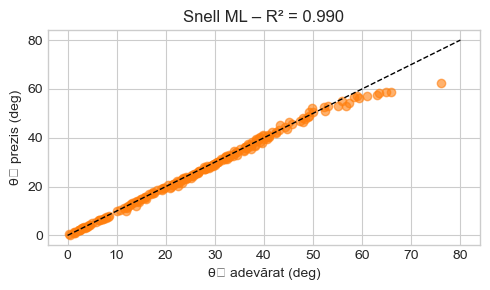

In [8]:

df = build_snell_dataset()
X = df[["n1", "n2", "theta1"]].values
y = df["theta2"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = MLPRegressor(hidden_layer_sizes=(32,32), max_iter=2000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plt.figure(figsize=(5, 3))
plt.scatter(y_test, y_pred, alpha=0.6, color="C1")
plt.plot([0, 80], [0, 80], "k--", lw=1)
plt.xlabel("θ₂ adevărat (deg)")
plt.ylabel("θ₂ prezis (deg)")
plt.title(f"Snell ML – R² = {r2_score(y_test, y_pred):.3f}")
plt.tight_layout()
plt.savefig("plots/snell_ml.png", dpi=300)

## Energie Foton

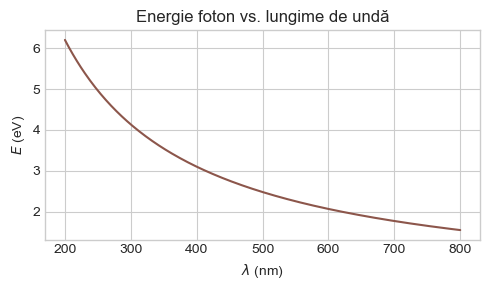

In [12]:
lam = np.linspace(200e-9, 800e-9, 300)  # 200-800 nm
E = 6.626e-34 * 3e8 / lam / 1.602e-19  # eV
plt.figure(figsize=(5, 3))
plt.plot(lam * 1e9, E, color="C5")
plt.xlabel(r"$\lambda$ (nm)")
plt.ylabel(r"$E$ (eV)")
plt.title("Energie foton vs. lungime de undă")
plt.tight_layout()
plt.savefig("plots/photon_energy.png", dpi=300)

## Regresie cu constrangere Snell

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def make_data(n=2000):
    rng = np.random.default_rng(42)
    n1 = rng.uniform(1.0, 1.5, n)
    n2 = rng.uniform(1.3, 2.0, n)
    t1 = rng.uniform(0, 75, n)
    sin_t1 = np.sin(np.radians(t1))
    sin_max = n2 / n1
    mask = sin_t1 <= sin_max
    n1, n2, t1, sin_t1 = n1[mask], n2[mask], t1[mask], sin_t1[mask]
    sin_t2 = sin_t1 * n1 / n2
    t2 = np.degrees(np.arcsin(sin_t2))
    return pd.DataFrame({"n1": n1, "n2": n2, "theta1": t1, "theta2": t2})

In [14]:
df = make_data()
X, y = df[["n1", "n2", "theta1"]].values, df["theta2"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

X_train_t = torch.tensor(X_train_s, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32, device=device)
y_test_t  = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1, 1)

In [15]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)
    def physics_loss(self, x):
        n1, n2, t1 = x[:, 0], x[:, 1], x[:, 2]
        t2 = self.forward(x).squeeze()
        sin_t1 = torch.sin(torch.deg2rad(t1))
        sin_t2 = torch.sin(torch.deg2rad(t2))
        return torch.mean((sin_t1 * n1 - sin_t2 * n2)**2)

In [16]:
model = PINN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

for epoch in range(800):
    opt.zero_grad()
    pred = model(X_train_t)
    data_loss = mse(pred, y_train_t)
    phys_loss = model.physics_loss(X_train_t)
    loss = data_loss + 0.1 * phys_loss
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print(f"Ep {epoch:3d} | data-loss {data_loss.item():.4f} | phys-loss {phys_loss.item():.4f}")

Ep   0 | data-loss 934.2280 | phys-loss 0.0003
Ep 100 | data-loss 688.8280 | phys-loss 0.0063
Ep 200 | data-loss 497.9475 | phys-loss 0.0267
Ep 300 | data-loss 388.4874 | phys-loss 0.0455
Ep 400 | data-loss 309.9833 | phys-loss 0.0657
Ep 500 | data-loss 252.1503 | phys-loss 0.0856
Ep 600 | data-loss 207.1434 | phys-loss 0.1026
Ep 700 | data-loss 170.0464 | phys-loss 0.1161


/var/folders/v9/l8dwmpq12gz43xchbrk2wxh80000gn/T/ipykernel_14580/3512243360.py:12: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/v9/l8dwmpq12gz43xchbrk2wxh80000gn/T/ipykernel_14580/3512243360.py:13: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig("plots/snell_physics_informed.png", dpi=300)
/usr/local/Caskroom/miniforge/base/envs/manim-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


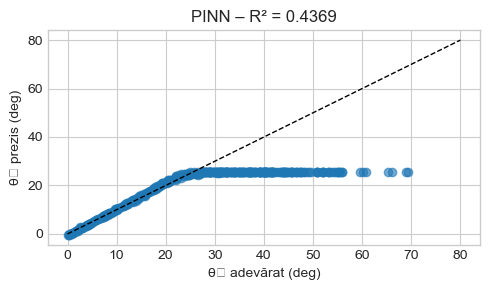

In [17]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t).cpu().numpy().squeeze()
r2 = 1 - np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2)

plt.figure(figsize=(5, 3))
plt.scatter(y_test, y_pred, alpha=0.6, color="C0")
plt.plot([0, 80], [0, 80], "k--", lw=1)
plt.xlabel("θ₂ adevărat (deg)")
plt.ylabel("θ₂ prezis (deg)")
plt.title(f"PINN – R² = {r2:.4f}")
plt.tight_layout()
plt.savefig("plots/snell_physics_informed.png", dpi=300)
plt.show()

## Poțential scalar, gradient, linii de câmp

In [18]:
import sympy as sp
from sympy import symbols, diff, sqrt, simplify

Potențial electrostatic scalar $ V(x,y) = 1/√(x²+y²) $

$
E = -∇V
$

In [ ]:



x, y = symbols("x y", real=True)
V = 1 / sqrt(x**2 + y**2)
Ex = -diff(V, x)
Ey = -diff(V, y)
print("V =", V)
print("E_x =", simplify(Ex))
print("E_y =", simplify(Ey))


V = 1/sqrt(x**2 + y**2)
E_x = x/(x**2 + y**2)**(3/2)
E_y = y/(x**2 + y**2)**(3/2)


In [22]:
X, Y = np.meshgrid(np.linspace(-2, 2, 100),
                   np.linspace(-2, 2, 100))
V_num = 1 / np.sqrt(X**2 + Y**2)
Ex_num = X / (X**2 + Y**2)**1.5
Ey_num = Y / (X**2 + Y**2)**1.5

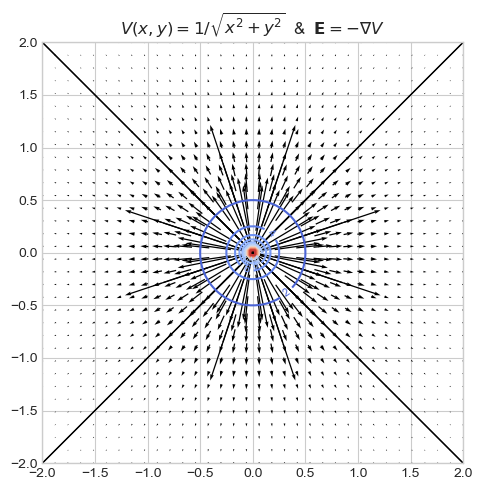

In [23]:
fig, ax = plt.subplots(figsize=(6, 5))
cont = ax.contour(X, Y, V_num, levels=20, cmap="coolwarm")
ax.clabel(cont, inline=True, fontsize=8)
ax.quiver(X[::3, ::3], Y[::3, ::3],
          Ex_num[::3, ::3], Ey_num[::3, ::3],
          pivot="mid", width=0.003, scale=50)
ax.set_aspect("equal")
ax.set_title(r"$V(x,y) = 1/\sqrt{x^2+y^2}$  &  $\mathbf{E}=-\nabla V$")
plt.tight_layout()
plt.savefig("plots/gradient_field.png", dpi=300)
plt.show()


## Pattern de interferență

Physics-Informed GAN minimal: generator produce pattern 2D
→ discriminator + constrângere fizică (interferență).

In [34]:
import torch, torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG = 128
Z_DIM = 32
LAM_TRUE = 500e-9   # λ target (m)
D_TRUE   = 20e-6    # d target (m)

In [35]:
def fringe(lam, d, size=128, L=1e-3):
    x = np.linspace(-L/2, L/2, size)
    y = np.linspace(-L/2, L/2, size)
    xx, yy = np.meshgrid(x, y)
    k = 2*np.pi/lam
    r1 = np.sqrt((yy - d/2)**2 + xx**2)
    r2 = np.sqrt((yy + d/2)**2 + xx**2)
    psi = np.exp(1j*k*r1) + np.exp(1j*k*r2)
    return np.abs(psi)**2

target = fringe(LAM_TRUE, D_TRUE, IMG)
target = torch.tensor(target/target.max(), dtype=torch.float32,
                      device=DEVICE).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)

In [36]:
class Generator(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256), nn.ReLU(True),
            nn.Linear(256, 512), nn.ReLU(True),
            nn.Linear(512, IMG*IMG), nn.Sigmoid())
    def forward(self, z):
        return self.net(z).view(-1, 1, IMG, IMG)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 4, 2, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(16, 32, 4, 2, 1), nn.LeakyReLU(0.2, True),
            nn.Flatten(),
            nn.Linear(32*(IMG//4)**2, 1))
    def forward(self, x):
        return self.net(x)

In [37]:
G = Generator().to(DEVICE)
D = Discriminator().to(DEVICE)
opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
bce = nn.BCEWithLogitsLoss()
lambda_phys = 5.0   # greutate constrângere fizică

def physics_loss(img):
    # FFT → spectru; vrem maxim la frecvența dată de d
    fft = torch.fft.rfft2(img, norm="ortho")
    amp = torch.abs(fft)
    # penalizează deviația de la media spectrală (simplu)
    return torch.mean((amp - amp.mean())**2)

In [38]:
BATCH = 64
EPOCHS = 200
for epoch in range(EPOCHS):
    # ---- Discriminator ----
    z = torch.randn(BATCH, Z_DIM, device=DEVICE)
    fake = G(z).detach()
    real_labels = torch.ones(BATCH, 1, device=DEVICE)
    fake_labels = torch.zeros(BATCH, 1, device=DEVICE)
    loss_real = bce(D(target.expand(BATCH, -1, -1, -1)), real_labels)
    loss_fake = bce(D(fake), fake_labels)
    loss_D = loss_real + loss_fake
    opt_D.zero_grad(); loss_D.backward(); opt_D.step()

    # ---- Generator ----
    z = torch.randn(BATCH, Z_DIM, device=DEVICE)
    fake = G(z)
    adv_loss = bce(D(fake), real_labels)
    phys = physics_loss(fake)
    loss_G = adv_loss + lambda_phys * phys
    opt_G.zero_grad(); loss_G.backward(); opt_G.step()

    if epoch % 20 == 0:
        print(f"Ep {epoch:3d} | D-loss {loss_D.item():.3f} | G-loss {loss_G.item():.3f} | phys {phys.item():.3f}")

Ep   0 | D-loss 1.398 | G-loss 3.147 | phys 0.492
Ep  20 | D-loss 0.550 | G-loss 2.969 | phys 0.275
Ep  40 | D-loss 0.317 | G-loss 3.503 | phys 0.280
Ep  60 | D-loss 0.875 | G-loss 3.777 | phys 0.503
Ep  80 | D-loss 1.137 | G-loss 4.072 | phys 0.571
Ep 100 | D-loss 1.195 | G-loss 3.762 | phys 0.531
Ep 120 | D-loss 1.242 | G-loss 3.690 | phys 0.539
Ep 140 | D-loss 1.273 | G-loss 3.684 | phys 0.557
Ep 160 | D-loss 1.450 | G-loss 3.839 | phys 0.561
Ep 180 | D-loss 1.406 | G-loss 3.690 | phys 0.560


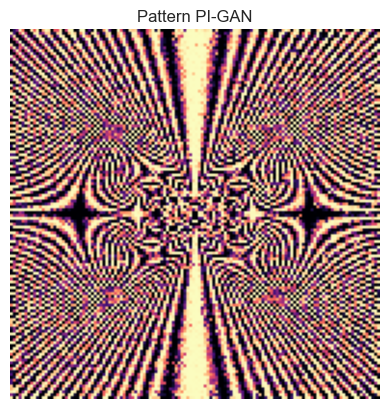

In [39]:
G.eval()
with torch.no_grad():
    out = G(torch.randn(1, Z_DIM, device=DEVICE)).squeeze().cpu().numpy()
plt.imshow(out, cmap='magma', origin='lower')
plt.axis('off'); plt.title("Pattern PI-GAN")
plt.savefig("plots/pi_gan.png", dpi=300, bbox_inches='tight')
plt.show()